In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
from sklearn import metrics

/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hoangnguyen/miniconda3/envs/pydata/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


build function to find optimal n_estimators
note: if learning_rate, reg_alpha, reg_lambda are not set
xgboost will use default values from https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
e.g. eta = 0.3 instead of 0.1
if they are set, eta, alpha, lambda will be overwritten
the best n_estimators is Name + 1

In [2]:
def modelfit(model, data, label, cv=5, early_stopping_rounds=50):
    params = model.get_params()
    params["num_class"] = 5
    dtrain = xgb.DMatrix(data, label)
    cvresult = xgb.cv(params, dtrain, num_boost_round=model.get_params()["n_estimators"],
                      nfold=cv, stratified=True,
                      metrics="mlogloss", early_stopping_rounds=early_stopping_rounds, verbose_eval=50)
    print(cvresult.iloc[-1])
    
def modelsubmit(model, train_data, train_label, test_data, label_list):
    model.fit(train_data, train_label, eval_metric="mlogloss")
    test_predict = model.predict_proba(test_data)
    sample = pd.read_csv("input/sample_submission.csv")
    sample[label_list] = test_predict
    sample.to_csv("submit/xgb_grid.csv", index=False)
    
# define scorer for log_loss
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Load data

In [3]:
# load data
with open("preprocessed_data.pkl", "rb") as f:
    train_data = pickle.load(f)
    train_label = pickle.load(f)
    label_list = pickle.load(f)

In [4]:
label_list

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

# Find n-estimators

In [5]:
xgb1 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=5, min_child_weight=1,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb1, train_data, train_label)

[0]	train-mlogloss:1.53742+0.00187154	test-mlogloss:1.53853+0.00174667
[50]	train-mlogloss:0.926942+0.00158316	test-mlogloss:0.968578+0.0050901
[100]	train-mlogloss:0.879978+0.00235064	test-mlogloss:0.959072+0.0056569
test-mlogloss-mean     0.958644
test-mlogloss-std      0.005995
train-mlogloss-mean    0.888134
train-mlogloss-std     0.002139
Name: 88, dtype: float64


# Grid search max_depth and min_child_weight
n-estimators = 89

In [6]:
# grid search max_depth and min_child_weight
param_grid = [{"max_depth": [3, 5, 7, 9],
               "min_child_weight": [1, 3, 5]}]
xgb2 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=89,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs2 = GridSearchCV(xgb2, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs2.fit(train_data, train_label)
gs2.grid_scores_, gs2.best_params_, gs2.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.972518 -   5.6s
[CV] min_child_weight=1, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ....... min_child_weight=1, max_depth=3, score=-0.963928 -   5.3s
[CV] min_child_weight=1, max_depth=3 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s


[CV] ....... min_child_weight=1, max_depth=3, score=-0.959014 -   5.5s
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.964562 -   6.1s
[CV] min_child_weight=1, max_depth=3 .................................
[CV] ....... min_child_weight=1, max_depth=3, score=-0.955106 -   5.5s
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.972968 -   5.7s
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.963739 -   5.3s
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.959238 -   5.3s
[CV] min_child_weight=3, max_depth=3 .................................
[CV] ....... min_child_weight=3, max_depth=3, score=-0.964899 -  10.6s
[CV] min_child_weight=3, max_depth=3 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  9.9min finished


([mean: -0.96303, std: 0.00587, params: {'min_child_weight': 1, 'max_depth': 3},
  mean: -0.96327, std: 0.00589, params: {'min_child_weight': 3, 'max_depth': 3},
  mean: -0.96340, std: 0.00592, params: {'min_child_weight': 5, 'max_depth': 3},
  mean: -0.95938, std: 0.00717, params: {'min_child_weight': 1, 'max_depth': 5},
  mean: -0.95957, std: 0.00722, params: {'min_child_weight': 3, 'max_depth': 5},
  mean: -0.95927, std: 0.00723, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: -0.97271, std: 0.00752, params: {'min_child_weight': 1, 'max_depth': 7},
  mean: -0.96990, std: 0.00688, params: {'min_child_weight': 3, 'max_depth': 7},
  mean: -0.96710, std: 0.00835, params: {'min_child_weight': 5, 'max_depth': 7},
  mean: -0.99796, std: 0.00652, params: {'min_child_weight': 1, 'max_depth': 9},
  mean: -0.98829, std: 0.00558, params: {'min_child_weight': 3, 'max_depth': 9},
  mean: -0.98143, std: 0.00625, params: {'min_child_weight': 5, 'max_depth': 9}],
 {'max_depth': 5, 'min_chil

In [7]:
# grid search max_depth and min_child_weight, second time
param_grid = [{"max_depth": [4, 5, 6],
               "min_child_weight": [4, 5, 6]}]
xgb3 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=89,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs3 = GridSearchCV(xgb3, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs3.fit(train_data, train_label)
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] min_child_weight=4, max_depth=4 .................................
[CV] ....... min_child_weight=4, max_depth=4, score=-0.970930 -   7.3s
[CV] min_child_weight=4, max_depth=4 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] ....... min_child_weight=4, max_depth=4, score=-0.960631 -   6.4s
[CV] min_child_weight=4, max_depth=4 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s


[CV] ....... min_child_weight=4, max_depth=4, score=-0.954530 -   6.7s
[CV] min_child_weight=4, max_depth=4 .................................
[CV] ....... min_child_weight=4, max_depth=4, score=-0.961336 -   6.5s
[CV] min_child_weight=4, max_depth=4 .................................
[CV] ....... min_child_weight=4, max_depth=4, score=-0.950114 -   6.1s
[CV] min_child_weight=5, max_depth=4 .................................
[CV] ....... min_child_weight=5, max_depth=4, score=-0.971230 -   6.7s
[CV] min_child_weight=5, max_depth=4 .................................
[CV] ....... min_child_weight=5, max_depth=4, score=-0.960101 -   6.8s
[CV] min_child_weight=5, max_depth=4 .................................
[CV] ....... min_child_weight=5, max_depth=4, score=-0.954690 -   6.8s
[CV] min_child_weight=5, max_depth=4 .................................
[CV] ....... min_child_weight=5, max_depth=4, score=-0.961896 -   6.5s
[CV] min_child_weight=5, max_depth=4 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  6.3min finished


([mean: -0.95951, std: 0.00704, params: {'min_child_weight': 4, 'max_depth': 4},
  mean: -0.95954, std: 0.00724, params: {'min_child_weight': 5, 'max_depth': 4},
  mean: -0.95993, std: 0.00739, params: {'min_child_weight': 6, 'max_depth': 4},
  mean: -0.95912, std: 0.00750, params: {'min_child_weight': 4, 'max_depth': 5},
  mean: -0.95927, std: 0.00723, params: {'min_child_weight': 5, 'max_depth': 5},
  mean: -0.95955, std: 0.00716, params: {'min_child_weight': 6, 'max_depth': 5},
  mean: -0.96218, std: 0.00737, params: {'min_child_weight': 4, 'max_depth': 6},
  mean: -0.96189, std: 0.00780, params: {'min_child_weight': 5, 'max_depth': 6},
  mean: -0.96185, std: 0.00791, params: {'min_child_weight': 6, 'max_depth': 6}],
 {'max_depth': 5, 'min_child_weight': 4},
 -0.9591225781283599)

In [10]:
# grid search max_depth and min_child_weight, third time
param_grid = [{"max_depth": [5],
               "min_child_weight": [5, 7, 9, 11]}]
xgb4 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=89,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs4 = GridSearchCV(xgb4, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs4.fit(train_data, train_label)
gs4.grid_scores_, gs4.best_params_, gs4.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ....... max_depth=5, min_child_weight=5, score=-0.970414 -   8.4s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ....... max_depth=5, min_child_weight=5, score=-0.961164 -  10.1s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.4s remaining:    0.0s


[CV] ....... max_depth=5, min_child_weight=5, score=-0.954693 -   8.6s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ....... max_depth=5, min_child_weight=5, score=-0.961245 -  10.2s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ....... max_depth=5, min_child_weight=5, score=-0.948838 -   9.2s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] ....... max_depth=5, min_child_weight=7, score=-0.970328 -   7.6s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] ....... max_depth=5, min_child_weight=7, score=-0.961209 -   7.7s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] ....... max_depth=5, min_child_weight=7, score=-0.955071 -   7.3s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] ....... max_depth=5, min_child_weight=7, score=-0.962651 -   7.3s
[CV] max_depth=5, min_child_weight=7 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.8min finished


([mean: -0.95927, std: 0.00723, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.95970, std: 0.00714, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.95974, std: 0.00727, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.95972, std: 0.00724, params: {'max_depth': 5, 'min_child_weight': 11}],
 {'max_depth': 5, 'min_child_weight': 5},
 -0.959273205411608)

In [10]:
# grid search max_depth and min_child_weight, third time
param_grid = [{"max_depth": [5],
               "min_child_weight": [11, 13, 15]}]
xgb5 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=85,
                         gamma=0,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs5 = GridSearchCV(xgb5, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs5.fit(train_data, train_label)
gs5.grid_scores_, gs5.best_params_, gs5.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ...... max_depth=5, min_child_weight=11, score=-0.965184 -   8.8s
[CV] max_depth=5, min_child_weight=11 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ...... max_depth=5, min_child_weight=11, score=-0.960488 -   8.2s
[CV] max_depth=5, min_child_weight=11 ................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.0s remaining:    0.0s


[CV] ...... max_depth=5, min_child_weight=11, score=-0.956339 -   8.3s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ...... max_depth=5, min_child_weight=11, score=-0.962720 -   7.5s
[CV] max_depth=5, min_child_weight=11 ................................
[CV] ...... max_depth=5, min_child_weight=11, score=-0.945821 -   9.8s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.965057 -   9.3s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.960377 -   7.9s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.955776 -   7.5s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] ...... max_depth=5, min_child_weight=13, score=-0.961424 -   7.3s
[CV] max_depth=5, min_child_weight=13 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.0min finished


([mean: -0.95811, std: 0.00680, params: {'max_depth': 5, 'min_child_weight': 11},
  mean: -0.95772, std: 0.00658, params: {'max_depth': 5, 'min_child_weight': 13},
  mean: -0.95828, std: 0.00674, params: {'max_depth': 5, 'min_child_weight': 15}],
 {'max_depth': 5, 'min_child_weight': 13},
 -0.9577240488364236)

In [15]:
# grid search max_depth and min_child_weight, third time
param_grid = [{"max_depth": [5],
               "min_child_weight": [5 , 6, 7]}]
xgb6 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=89,
                         gamma=0.3,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs6 = GridSearchCV(xgb6, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs6.fit(train_data, train_label)
gs6.grid_scores_, gs6.best_params_, gs6.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ....... max_depth=5, min_child_weight=5, score=-0.969864 -   9.0s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ....... max_depth=5, min_child_weight=5, score=-0.961715 -   8.9s
[CV] max_depth=5, min_child_weight=5 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.9s remaining:    0.0s


[CV] ....... max_depth=5, min_child_weight=5, score=-0.953492 -   8.1s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ....... max_depth=5, min_child_weight=5, score=-0.962051 -   9.2s
[CV] max_depth=5, min_child_weight=5 .................................
[CV] ....... max_depth=5, min_child_weight=5, score=-0.948438 -   9.0s
[CV] max_depth=5, min_child_weight=6 .................................
[CV] ....... max_depth=5, min_child_weight=6, score=-0.970293 -   8.4s
[CV] max_depth=5, min_child_weight=6 .................................
[CV] ....... max_depth=5, min_child_weight=6, score=-0.961091 -   8.4s
[CV] max_depth=5, min_child_weight=6 .................................
[CV] ....... max_depth=5, min_child_weight=6, score=-0.955325 -   8.5s
[CV] max_depth=5, min_child_weight=6 .................................
[CV] ....... max_depth=5, min_child_weight=6, score=-0.962389 -   8.3s
[CV] max_depth=5, min_child_weight=6 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.1min finished


([mean: -0.95911, std: 0.00744, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.95963, std: 0.00713, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.95926, std: 0.00740, params: {'max_depth': 5, 'min_child_weight': 7}],
 {'max_depth': 5, 'min_child_weight': 5},
 -0.959114719214701)

# Grid search gamma
n_estimators = 89, max_depth = 5, min_child_weight = 4

In [8]:
param_grid = [{"gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5]}]
xgb7 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=89,
                         max_depth=5, min_child_weight=4,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs7 = GridSearchCV(xgb7, param_grid, fit_params={"eval_metric": "mlogloss"},
                  scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs7.fit(train_data, train_label)
gs7.grid_scores_, gs7.best_params_, gs7.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.970870 -   8.3s
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] ............................... gamma=0, score=-0.961232 -   8.2s
[CV] gamma=0 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.6s remaining:    0.0s


[CV] ............................... gamma=0, score=-0.953740 -   8.3s
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.960958 -   8.7s
[CV] gamma=0 .........................................................
[CV] ............................... gamma=0, score=-0.948798 -   8.7s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.970807 -   8.1s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.961486 -   8.4s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.954130 -   8.3s
[CV] gamma=0.1 .......................................................
[CV] ............................. gamma=0.1, score=-0.961207 -   8.4s
[CV] gamma=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.2min finished


([mean: -0.95912, std: 0.00750, params: {'gamma': 0},
  mean: -0.95934, std: 0.00738, params: {'gamma': 0.1},
  mean: -0.95907, std: 0.00735, params: {'gamma': 0.2},
  mean: -0.95948, std: 0.00725, params: {'gamma': 0.3},
  mean: -0.95913, std: 0.00735, params: {'gamma': 0.4},
  mean: -0.95913, std: 0.00751, params: {'gamma': 0.5}],
 {'gamma': 0.2},
 -0.9590681570588281)

# Find n-estimators
n_estimators = 89, max_depth = 5, min_child_weight = 4, gamma = 0.2

In [9]:
xgb8 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=1000,
                         max_depth=5, min_child_weight=4,
                         gamma=0.2,
                         subsample=0.8, colsample_bytree=0.8,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb8, train_data, train_label)

[0]	train-mlogloss:1.53757+0.00184999	test-mlogloss:1.5386+0.00173039
[50]	train-mlogloss:0.932055+0.00163329	test-mlogloss:0.968995+0.00488623
[100]	train-mlogloss:0.890517+0.00243664	test-mlogloss:0.959435+0.00516202
test-mlogloss-mean     0.959077
test-mlogloss-std      0.005278
train-mlogloss-mean    0.896324
train-mlogloss-std     0.002335
Name: 90, dtype: float64


# Grid search subsample, colsample_bytree
n_estimators = 91, max_depth = 5, min_child_weight = 4, gamma = 0.2

In [10]:
param_grid9 = [{"subsample": [0.6, 0.7, 0.8, 0.9],
                 "colsample_bytree": [0.6, 0.7, 0.8, 0.9]}]
xgb9 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=91,
                         max_depth=5, min_child_weight=4,
                         gamma=0.2,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs9 = GridSearchCV(xgb9, param_grid9, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs9.fit(train_data, train_label)
gs9.grid_scores_, gs9.best_params_, gs9.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.971021 -   7.5s
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.960006 -   7.1s
[CV] colsample_bytree=0.6, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.6s remaining:    0.0s


[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.954391 -   7.1s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.959503 -   7.1s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] ... colsample_bytree=0.6, subsample=0.6, score=-0.947782 -   7.6s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.970369 -   7.6s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.961814 -   6.8s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.953759 -   7.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] ... colsample_bytree=0.6, subsample=0.7, score=-0.959762 -   7.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 10.0min finished


([mean: -0.95854, std: 0.00764, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.95831, std: 0.00820, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.95812, std: 0.00752, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.95812, std: 0.00803, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.95866, std: 0.00823, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.95819, std: 0.00833, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.95906, std: 0.00719, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.95925, std: 0.00758, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.95871, std: 0.00821, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.95908, std: 0.00764, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.95899, std: 0.00733, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.95996, std: 0.00797, params: {'colsample_bytree': 0.8,

In [11]:
param_grid10 = [{"subsample": [0.9, 0.95, 1],
                 "colsample_bytree": [0.55, 0.6, 0.65]}]
xgb10 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=91,
                         max_depth=5, min_child_weight=4,
                         gamma=0.2,
                         reg_alpha=0, reg_lambda=1,
                         objective="multi:softprob")
gs10 = GridSearchCV(xgb10, param_grid10, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs10.fit(train_data, train_label)
gs10.grid_scores_, gs10.best_params_, gs10.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] colsample_bytree=0.55, subsample=0.9 ............................
[CV] .. colsample_bytree=0.55, subsample=0.9, score=-0.971104 -   6.2s
[CV] colsample_bytree=0.55, subsample=0.9 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] .. colsample_bytree=0.55, subsample=0.9, score=-0.960538 -   5.8s
[CV] colsample_bytree=0.55, subsample=0.9 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s


[CV] .. colsample_bytree=0.55, subsample=0.9, score=-0.954010 -   5.8s
[CV] colsample_bytree=0.55, subsample=0.9 ............................
[CV] .. colsample_bytree=0.55, subsample=0.9, score=-0.960518 -   5.8s
[CV] colsample_bytree=0.55, subsample=0.9 ............................
[CV] .. colsample_bytree=0.55, subsample=0.9, score=-0.947070 -   5.8s
[CV] colsample_bytree=0.55, subsample=0.95 ...........................
[CV] . colsample_bytree=0.55, subsample=0.95, score=-0.970068 -   5.7s
[CV] colsample_bytree=0.55, subsample=0.95 ...........................
[CV] . colsample_bytree=0.55, subsample=0.95, score=-0.960233 -   5.6s
[CV] colsample_bytree=0.55, subsample=0.95 ...........................
[CV] . colsample_bytree=0.55, subsample=0.95, score=-0.953503 -   5.6s
[CV] colsample_bytree=0.55, subsample=0.95 ...........................
[CV] . colsample_bytree=0.55, subsample=0.95, score=-0.961087 -   5.7s
[CV] colsample_bytree=0.55, subsample=0.95 ...........................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.4min finished


([mean: -0.95865, std: 0.00797, params: {'colsample_bytree': 0.55, 'subsample': 0.9},
  mean: -0.95836, std: 0.00779, params: {'colsample_bytree': 0.55, 'subsample': 0.95},
  mean: -0.95906, std: 0.00790, params: {'colsample_bytree': 0.55, 'subsample': 1},
  mean: -0.95812, std: 0.00803, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.95871, std: 0.00764, params: {'colsample_bytree': 0.6, 'subsample': 0.95},
  mean: -0.95903, std: 0.00812, params: {'colsample_bytree': 0.6, 'subsample': 1},
  mean: -0.95824, std: 0.00719, params: {'colsample_bytree': 0.65, 'subsample': 0.9},
  mean: -0.95871, std: 0.00757, params: {'colsample_bytree': 0.65, 'subsample': 0.95},
  mean: -0.95954, std: 0.00782, params: {'colsample_bytree': 0.65, 'subsample': 1}],
 {'colsample_bytree': 0.6, 'subsample': 0.9},
 -0.9581191410274573)

# Grid search reg_alpha
n_estimators = 91, max_depth = 5, min_child_weight = 4, gamma = 0.2, colsample_bytree = 0.6, subsample = 0.9

In [12]:
param_grid11 = [{"reg_alpha": [0.001, 0.005, 0.01, 0.05]}]
xgb11 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=91,
                         max_depth=5, min_child_weight=4,
                         gamma=0.2,
                         subsample=0.9, colsample_bytree=0.6,
                         reg_lambda=1,
                         objective="multi:softprob")
gs11 = GridSearchCV(xgb11, param_grid11, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs11.fit(train_data, train_label)
gs11.grid_scores_, gs11.best_params_, gs11.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.970626 -   5.9s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] ....................... reg_alpha=0.001, score=-0.959448 -   5.9s
[CV] reg_alpha=0.001 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.8s remaining:    0.0s


[CV] ....................... reg_alpha=0.001, score=-0.953699 -   5.9s
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.960041 -   5.9s
[CV] reg_alpha=0.001 .................................................
[CV] ....................... reg_alpha=0.001, score=-0.946781 -   5.9s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.970800 -   5.9s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.959610 -   5.8s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.953644 -   6.0s
[CV] reg_alpha=0.005 .................................................
[CV] ....................... reg_alpha=0.005, score=-0.960286 -   6.0s
[CV] reg_alpha=0.005 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.1min finished


([mean: -0.95812, std: 0.00787, params: {'reg_alpha': 0.001},
  mean: -0.95820, std: 0.00799, params: {'reg_alpha': 0.005},
  mean: -0.95832, std: 0.00800, params: {'reg_alpha': 0.01},
  mean: -0.95808, std: 0.00784, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 -0.958079401909857)

# Grid search reg_lambda
n_estimators = 91, max_depth = 5, min_child_weight = 4, 
gamma = 0.2, colsample_bytree = 0.6, subsample = 0.9, reg_alpha = 0.05

In [13]:
param_grid12 = [{"reg_lambda": [1e-5, 0.01, 0.1, 1, 100]}]
xgb12 = xgb.XGBClassifier(learning_rate=0.1, n_estimators=91,
                         max_depth=5, min_child_weight=4,
                         gamma=0.2,
                         subsample=0.9, colsample_bytree=0.6,
                         reg_alpha=0.001,
                         objective="multi:softprob")
gs12 = GridSearchCV(xgb12, param_grid12, fit_params={"eval_metric": "mlogloss"},
                    scoring=scorer, n_jobs=1, cv=5, verbose=3)
gs12.fit(train_data, train_label)
gs12.grid_scores_, gs12.best_params_, gs12.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.971473 -   8.4s
[CV] reg_lambda=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ...................... reg_lambda=1e-05, score=-0.960077 -   6.6s
[CV] reg_lambda=1e-05 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s


[CV] ...................... reg_lambda=1e-05, score=-0.953975 -   6.8s
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.959665 -   6.7s
[CV] reg_lambda=1e-05 ................................................
[CV] ...................... reg_lambda=1e-05, score=-0.946569 -   6.7s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.971086 -   6.6s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.960015 -   6.6s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.953913 -   6.6s
[CV] reg_lambda=0.01 .................................................
[CV] ....................... reg_lambda=0.01, score=-0.960262 -   6.5s
[CV] reg_lambda=0.01 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.8min finished


([mean: -0.95836, std: 0.00818, params: {'reg_lambda': 1e-05},
  mean: -0.95841, std: 0.00804, params: {'reg_lambda': 0.01},
  mean: -0.95866, std: 0.00802, params: {'reg_lambda': 0.1},
  mean: -0.95812, std: 0.00787, params: {'reg_lambda': 1},
  mean: -0.96669, std: 0.00747, params: {'reg_lambda': 100}],
 {'reg_lambda': 1},
 -0.9581219464078035)

# Find n_estimators final
n_estimators = 91, max_depth = 5, min_child_weight = 4, 
gamma = 0.2, colsample_bytree = 0.6, subsample = 0.9, reg_alpha = 0.05, reg_lambda = 1

In [14]:
# find n_estimators
xgb13 = xgb.XGBClassifier(learning_rate=0.01, n_estimators=5000,
                         max_depth=5, min_child_weight=4,
                         gamma=0.2,
                         subsample=0.9, colsample_bytree=0.6,
                         reg_alpha=0.05, reg_lambda=1,
                         objective="multi:softprob")
modelfit(xgb13, train_data, train_label)

[0]	train-mlogloss:1.6026+0.000379528	test-mlogloss:1.60272+0.000348781
[50]	train-mlogloss:1.34637+0.00192956	test-mlogloss:1.35093+0.000862451
[100]	train-mlogloss:1.20299+0.00134469	test-mlogloss:1.21152+0.00209279
[150]	train-mlogloss:1.11414+0.00147555	test-mlogloss:1.12623+0.00296595
[200]	train-mlogloss:1.05715+0.00152165	test-mlogloss:1.07253+0.00347275
[250]	train-mlogloss:1.01875+0.00153153	test-mlogloss:1.03723+0.00399239
[300]	train-mlogloss:0.991967+0.00162498	test-mlogloss:1.01352+0.00405364
[350]	train-mlogloss:0.972624+0.00153463	test-mlogloss:0.997153+0.00434659
[400]	train-mlogloss:0.958224+0.0016092	test-mlogloss:0.985641+0.00440636
[450]	train-mlogloss:0.947219+0.00164812	test-mlogloss:0.977461+0.00463482
[500]	train-mlogloss:0.938599+0.00167127	test-mlogloss:0.971611+0.00481616
[550]	train-mlogloss:0.931605+0.00162002	test-mlogloss:0.967367+0.00496798
[600]	train-mlogloss:0.925753+0.00166621	test-mlogloss:0.964195+0.00510848
[650]	train-mlogloss:0.920821+0.00171855

In [15]:
xgbfinal = xgb.XGBClassifier(learning_rate=0.01, n_estimators=1024,
                         max_depth=5, min_child_weight=4,
                         gamma=0.2,
                         subsample=0.9, colsample_bytree=0.6,
                         reg_alpha=0.05, reg_lambda=1,
                         objective="multi:softprob")

In [16]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [17]:
xgbfinal.fit(train_data,train_label)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0.2, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=None, n_estimators=1024, nthread=-1,
       objective='multi:softprob', reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

# Accuracy and score

In [18]:
kfold = StratifiedKFold(train_label, n_folds=10, random_state=7)
results = cross_val_score(xgbfinal, train_data, train_label, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 59.67% (1.00%)


In [19]:
scores = cross_val_score(xgbfinal, train_data, train_label, cv=kfold, scoring='neg_log_loss')
print(scores)

[-0.97834758 -0.95942021 -0.9626395  -0.95492432 -0.93670775 -0.96352959
 -0.9644252  -0.95558627 -0.94983412 -0.93538876]


In [20]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.96 (+/- 0.02)


In [ ]:
precision_scores = cross_val_score(rf, train_data, train_label, cv=kfold, scoring='precision_micro')
print(precision_scores)

In [ ]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

In [ ]:
recall_scores = cross_val_score(rf, train_data, train_label, cv=kfold, scoring='recall_micro')
print(recall_scores)

In [ ]:
print("Accuracy: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))

# Feature importances

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [22]:
features = ['Size', 'HasName_0', 'HasName_1', 'TimeofDay_lateday',
       'TimeofDay_midday', 'TimeofDay_morning', 'TimeofDay_night', 'WeekDay_0',
       'WeekDay_1', 'WeekDay_2', 'WeekDay_3', 'WeekDay_4', 'WeekDay_5',
       'WeekDay_6', 'IsIntact_0', 'IsIntact_1','Sex_Female', 'Sex_Male', 'IsMixBreed_0', 
        'IsMixBreed_1','MixorMultipleorSimple_Mix', 'MixorMultipleorSimple_Multiple',
       'MixorMultipleorSimple_Simple', 'Group_Herding', 'Group_Hound',
       'Group_NonSporting', 'Group_PitBull', 'Group_Sporting', 'Group_Terrier',
       'Group_Toy', 'Group_Unknown', 'Group_Working', 'IsMixColor_0',
       'IsMixColor_1']
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(xgbfinal.booster().get_fscore())
#ts.index = ts.reset_index()['index'].map(mapFeat)
#ts.order().plot(kind="barh", title=("features importance"))

In [23]:
ts = ts.sort_values(ascending=False)

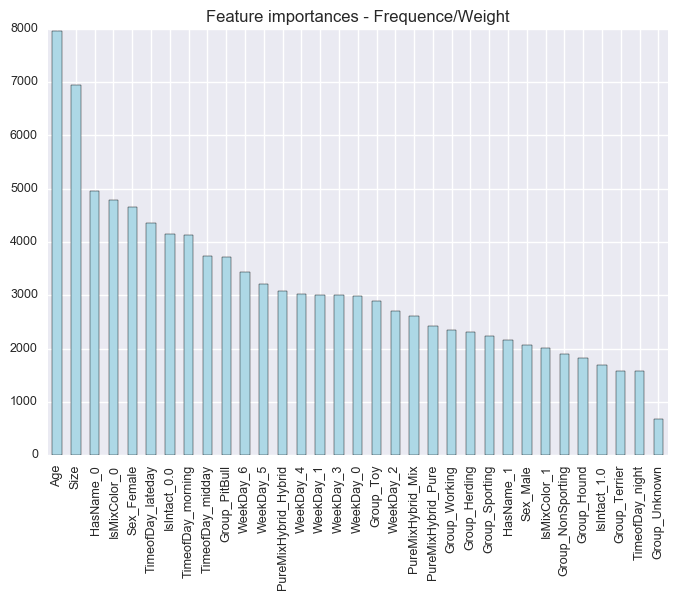

In [24]:
plt.figure(); ts.plot(color="lightblue", kind="bar", title="Feature importances - Frequence/Weight",fontsize=9,)

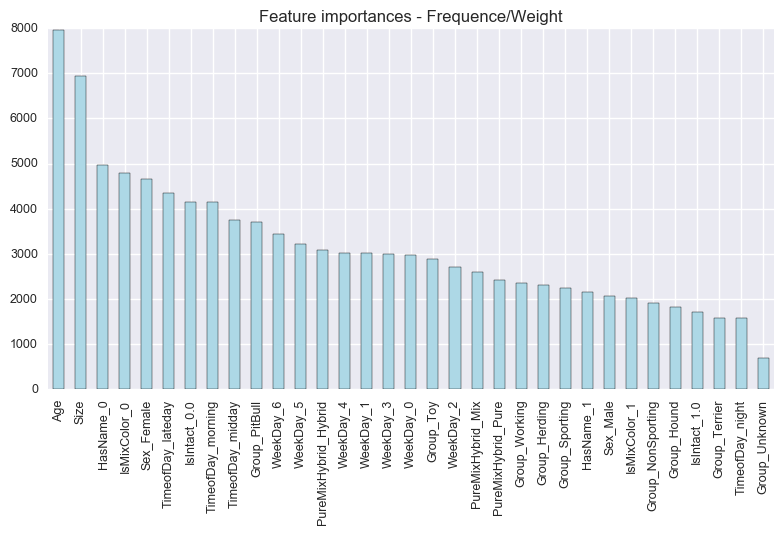

In [25]:
plt.figure(); ts.plot(color="lightblue", kind="bar", title="Feature importances - Frequence/Weight",fontsize=9)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("gain.png")

In [26]:
#xgb.plot_importance(xgbfinal)

In [27]:
ts1 = pd.Series(xgbfinal.booster().get_score(importance_type = "gain"))

In [28]:
ts1 = ts1.sort_values(ascending=False)

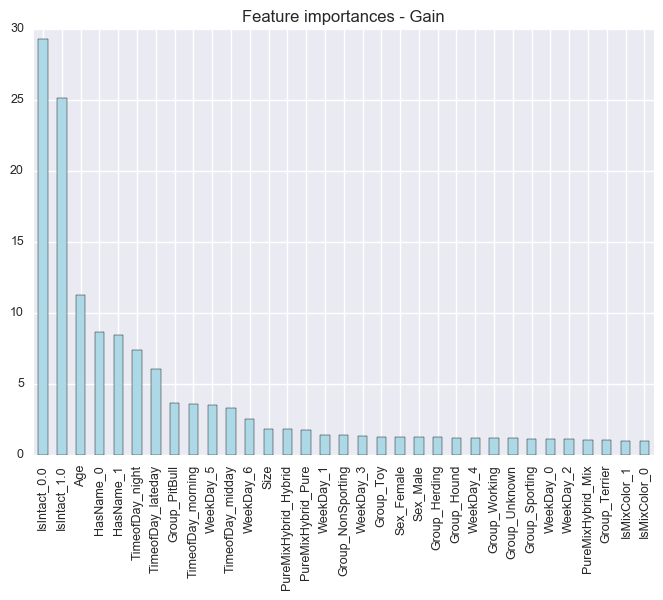

In [29]:
plt.figure(); ts1.plot(color="lightblue", kind="bar", title="Feature importances - Gain",fontsize=9)

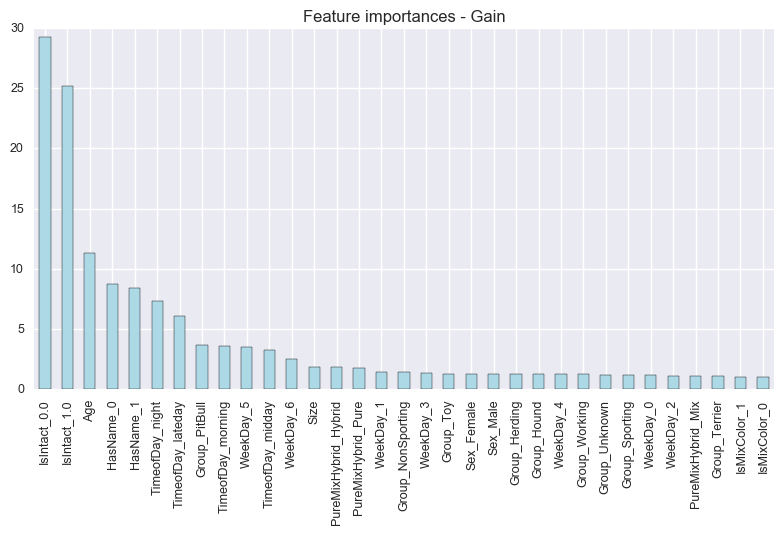

In [30]:
plt.figure(); ts1.plot(color="lightblue", kind="bar", title="Feature importances - Gain",fontsize=9)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("gain.png")

In [31]:
ts2 = pd.Series(xgbfinal.booster().get_score(importance_type = "weight"))

In [32]:
ts2 = ts2.sort_values(ascending=False)

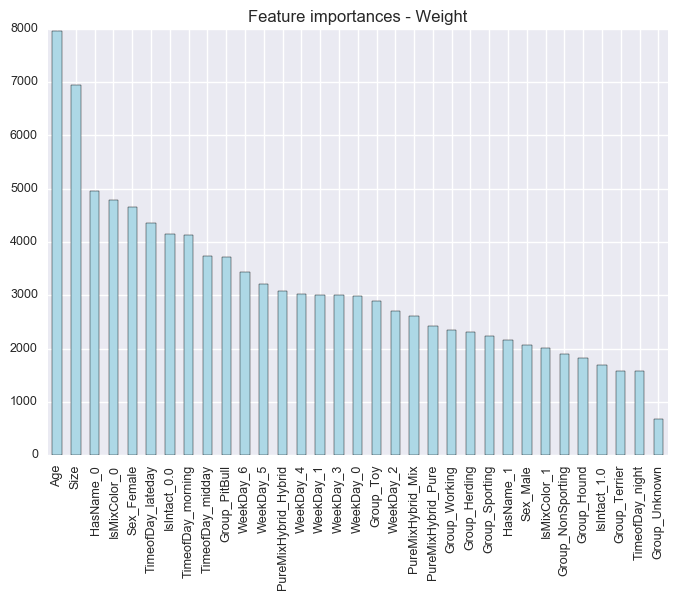

In [33]:
plt.figure(); ts2.plot(color="lightblue", kind="bar", title="Feature importances - Weight",fontsize=9,)

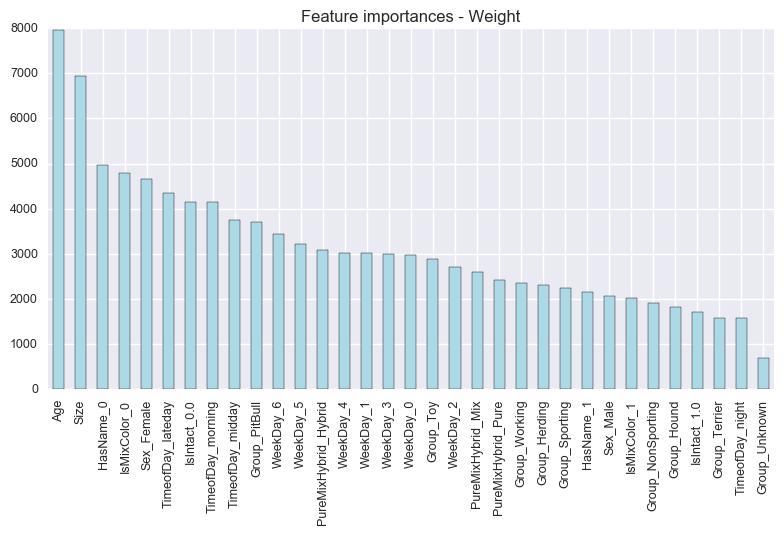

In [34]:
plt.figure(); ts2.plot(color="lightblue", kind="bar", title="Feature importances - Weight",fontsize=9,)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("weight.png")

In [35]:
ts3 = pd.Series(xgbfinal.booster().get_score(importance_type = "cover"))

In [36]:
ts3 = ts3.sort_values(ascending=False)

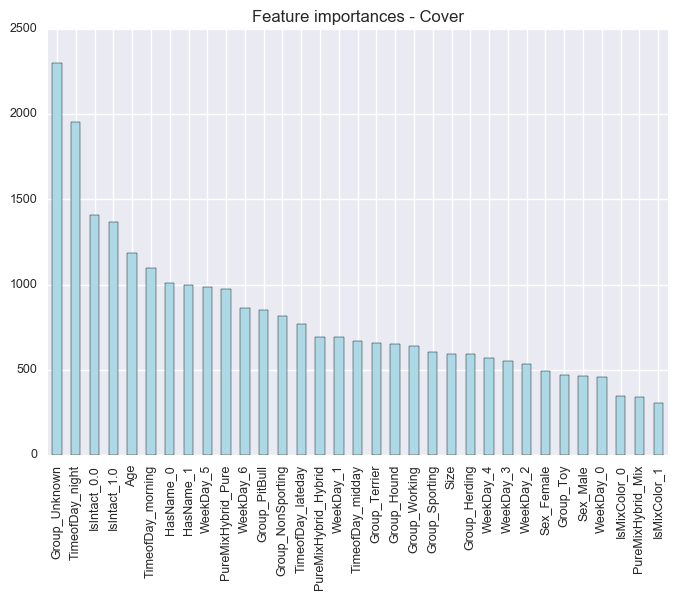

In [37]:
plt.figure(); ts3.plot(color="lightblue", kind="bar", title="Feature importances - Cover",fontsize=9,)

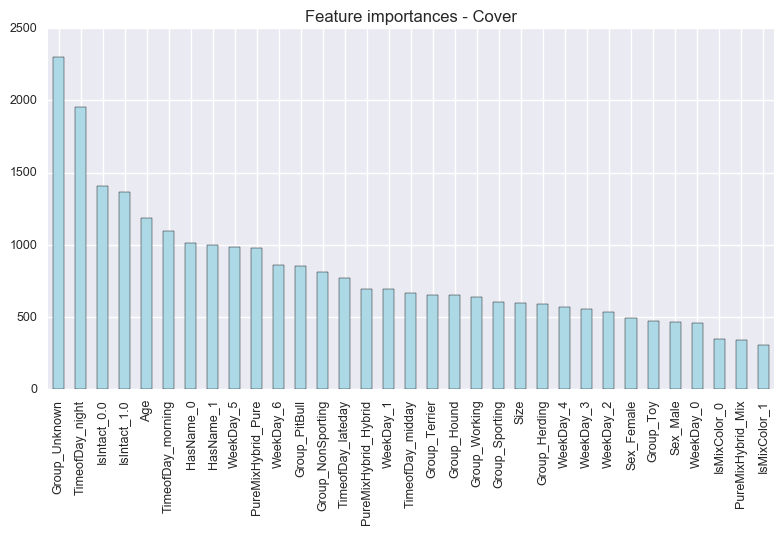

In [38]:
plt.figure(); ts3.plot(color="lightblue", kind="bar", title="Feature importances - Cover",fontsize=9,)
plt.tight_layout(rect=[0,0,1,1], h_pad=0.0)
plt.savefig("cover.png")